# House Prices Prediction

![image](https://storage.googleapis.com/kaggle-competitions/kaggle/5407/media/housesbanner.png)

## Overview

* [Required Libraries and Data](#1)
* [Data Cleaning](#2)
    - [Handling Missing Values](#2-1)
    - [Fixing Columns Data Types](#2-2)
* [Exploratory Data Analysis](#3)
    - [Correlated Predictor Variables](#3-1)
    - [Target Correlations](#3-2)
    - [Removing Identified Outliers](#3-3)
* [Data Preprocessing](#4)
* [Modeling](#5)
* [Competition Submission](#6)

## <span id="1"></span>Required Libraries and Data

In [1]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    StandardScaler,
    RobustScaler,
    MinMaxScaler,
    FunctionTransformer,
    OrdinalEncoder,
    OneHotEncoder
)
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression, Lasso, Ridge, SGDRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from xgboost import XGBRegressor
from pandas.api.types import is_numeric_dtype, is_categorical_dtype

import warnings
warnings.filterwarnings("ignore")

import random
%matplotlib inline

seed = 42
random.seed(seed)
np.random.seed(seed)

pd.set_option("display.float_format", lambda x: "{:.3f}".format(x))
sns.set_style("darkgrid")

df_train = pd.read_csv("../input/house-prices-advanced-regression-techniques/train.csv", index_col=0)

In [2]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

## <span id="2"></span>Data Cleaning

In [3]:
for column in df_train.columns.values:
    print(f"{column} ({df_train[column].dtype}):")
    unique = df_train[column].unique()

    if is_numeric_dtype(unique):
        unique = np.sort(unique)

    print(unique, "\n")

MSSubClass (int64):
[ 20  30  40  45  50  60  70  75  80  85  90 120 160 180 190] 

MSZoning (object):
['RL' 'RM' 'C (all)' 'FV' 'RH'] 

LotFrontage (float64):
[ 21.  24.  30.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.
  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.
  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.  84.
  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.  98.
  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111. 112.
 114. 115. 116. 118. 120. 121. 122. 124. 128. 129. 130. 134. 137. 138.
 140. 141. 144. 149. 150. 152. 153. 160. 168. 174. 182. 313.  nan] 

LotArea (int64):
[  1300   1477   1491 ... 159000 164660 215245] 

Street (object):
['Pave' 'Grvl'] 

Alley (object):
[nan 'Grvl' 'Pave'] 

LotShape (object):
['Reg' 'IR1' 'IR2' 'IR3'] 

LandContour (object):
['Lvl' 'Bnk' 'Low' 'HLS'] 

Utilities (object):
['AllPub' 'NoSeWa

### <span id="2-1"></span>Handling Missing Values

In [4]:
missing = df_train.isnull().sum().sort_values(ascending=False)
missing = missing[missing > 0]
missing = missing.to_frame().rename(columns={0: "Count"})
missing["%"] = np.round((missing["Count"] / len(df_train)) * 100, 2)
missing

,Count,%
PoolQC,1453,99.520
MiscFeature,1406,96.300
Alley,1369,93.770
Fence,1179,80.750
FireplaceQu,690,47.260
LotFrontage,259,17.740
GarageYrBlt,81,5.550
GarageCond,81,5.550
GarageType,81,5.550
GarageFinish,81,5.550


In [5]:
# removing columns with 45+% of missing values
missing_threshold = 45
df_train.drop(missing[missing["%"] >= missing_threshold].index, axis=1, inplace=True)

In [6]:
def handle_missing(df: pd.DataFrame):
    df = df.copy()
    columns = df.columns.values
    
    for col in ["GarageCond", "GarageType", "GarageFinish", "GarageQual"]:
        if col in columns:
            df[col] = df[col].fillna("None")

    for col in ["BsmtFinType2", "BsmtExposure", "BsmtQual", "BsmtCond", "BsmtFinType1"]:
        if col in columns:
            df[col] = df[col].fillna("None")
        
    if "MasVnrType" in columns:
        df["MasVnrType"] = df["MasVnrType"].fillna("None")
    
    if "MasVnrArea" in columns:
        df["MasVnrArea"] = df["MasVnrArea"].fillna(0)
        
    if "Electrical" in columns:
        df.dropna(subset=["Electrical"], axis=0, inplace=True)
    
    return df

df_train = handle_missing(df_train)

### <span id="2-2"></span>Fixing Columns Data Types

In [7]:
def handle_dtypes(df):
    df = df.copy()
    columns = df.columns.values
    
    if "MSSubClass" in columns:
        df["MSSubClass"] = df["MSSubClass"].astype(str)
        df["GarageYrBlt"] = df["GarageYrBlt"].astype(int, errors="ignore")
    
    return df

df_train = handle_dtypes(df_train)

## <span id="3"></span>Exploratory Data Analysis

In [8]:
df_train.describe()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1200.000,1459.000,1459.000,1459.000,1459.000,1459.000,1459.000,1459.000,1459.000,1459.000,...,1459.000,1459.000,1459.000,1459.000,1459.000,1459.000,1459.000,1459.000,1459.000,1459.000
mean,70.047,10517.364,6.100,5.576,1971.244,1984.851,103.188,443.944,46.581,567.366,...,94.241,46.692,21.969,3.412,15.071,2.761,43.519,6.323,2007.816,180930.395
std,24.295,9984.666,1.383,1.113,30.200,20.644,180.773,456.106,161.370,441.992,...,125.382,66.267,61.137,29.327,55.775,40.191,496.292,2.704,1.329,79468.964
min,21.000,1300.000,1.000,1.000,1872.000,1950.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,2006.000,34900.000
25%,59.000,7549.000,5.000,5.000,1954.000,1967.000,0.000,0.000,0.000,223.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,5.000,2007.000,129950.000
50%,69.000,9477.000,6.000,5.000,1973.000,1994.000,0.000,384.000,0.000,479.000,...,0.000,25.000,0.000,0.000,0.000,0.000,0.000,6.000,2008.000,163000.000
75%,80.000,11603.000,7.000,6.000,2000.000,2004.000,164.500,712.500,0.000,808.000,...,168.000,68.000,0.000,0.000,0.000,0.000,0.000,8.000,2009.000,214000.000
max,313.000,215245.000,10.000,9.000,2010.000,2010.000,1600.000,5644.000,1474.000,2336.000,...,857.000,547.000,552.000,508.000,480.000,738.000,15500.000,12.000,2010.000,755000.000


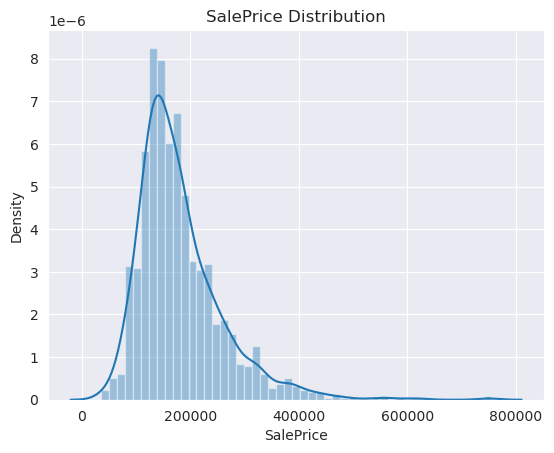

In [9]:
plt.title("SalePrice Distribution")
sns.distplot(df_train["SalePrice"])
plt.show()

In [10]:
skewness = np.round(df_train["SalePrice"].skew(), 2)
kurtosis = np.round(df_train["SalePrice"].kurt(), 2)
print(f"Skewness: {skewness}\nKurtosis: {kurtosis}")

Skewness: 1.88
Kurtosis: 6.53


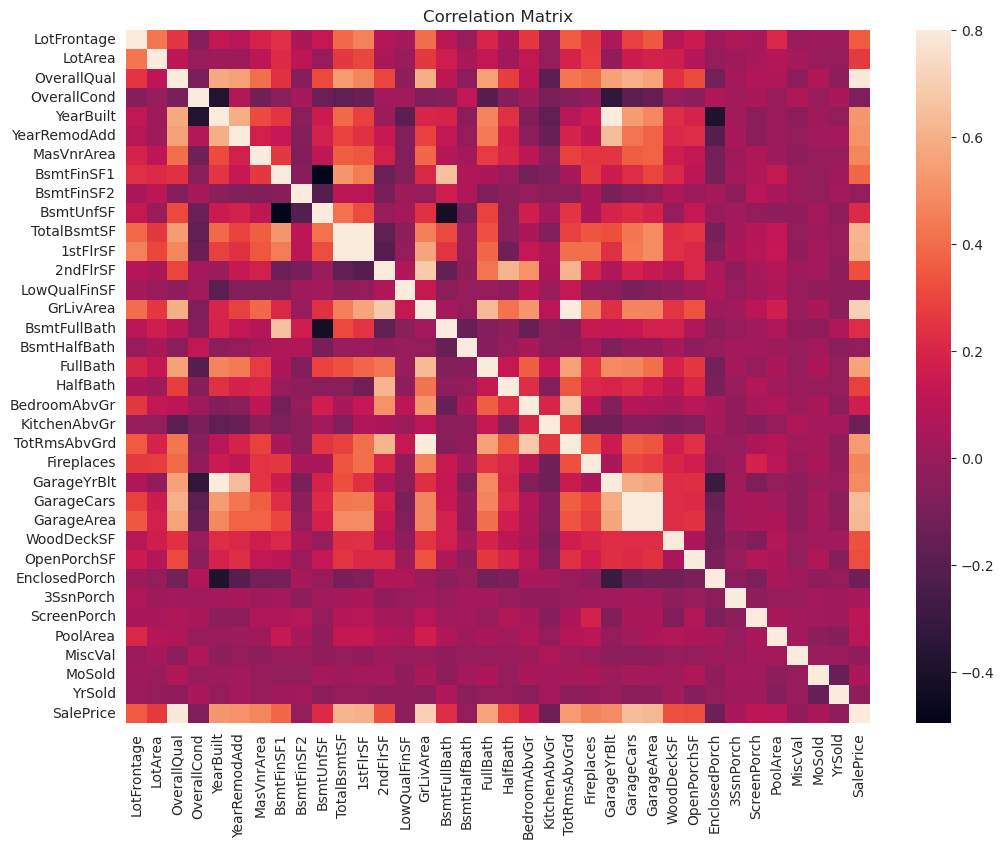

In [11]:
corr = df_train.corr()
plt.figure(figsize=(12, 9))
plt.title("Correlation Matrix")
sns.heatmap(corr, cbar=True, vmax=0.8)
plt.show()

### <span id="3-1"></span>Correlated Predictor Variables

In [12]:
pcorr = df_train.drop("SalePrice", axis=1).corr()
upper = np.abs(np.triu(pcorr))
np.fill_diagonal(upper, 0)
high_corrs = np.argwhere(upper >= 0.7)

for row_idx, col_idx in high_corrs:
    row_index, col_index = pcorr.index.values[row_idx], pcorr.columns.values[col_idx]
    print(f"{row_index} / {col_index}: {np.round(pcorr.loc[row_index, col_index], 2)}")

YearBuilt / GarageYrBlt: 0.83
TotalBsmtSF / 1stFlrSF: 0.82
GrLivArea / TotRmsAbvGrd: 0.83
GarageCars / GarageArea: 0.88


### <span id="3-2"></span>Target Correlations

In [13]:
top_10_corrs = corr.loc[:, "SalePrice"].drop("SalePrice", axis=0).abs().nlargest(10).index.values
top_10_corrs = corr.loc[top_10_corrs, "SalePrice"]
top_10_corrs

OverallQual    0.791
GrLivArea      0.709
GarageCars     0.640
GarageArea     0.623
TotalBsmtSF    0.614
1stFlrSF       0.606
FullBath       0.561
TotRmsAbvGrd   0.534
YearBuilt      0.523
YearRemodAdd   0.507
Name: SalePrice, dtype: float64

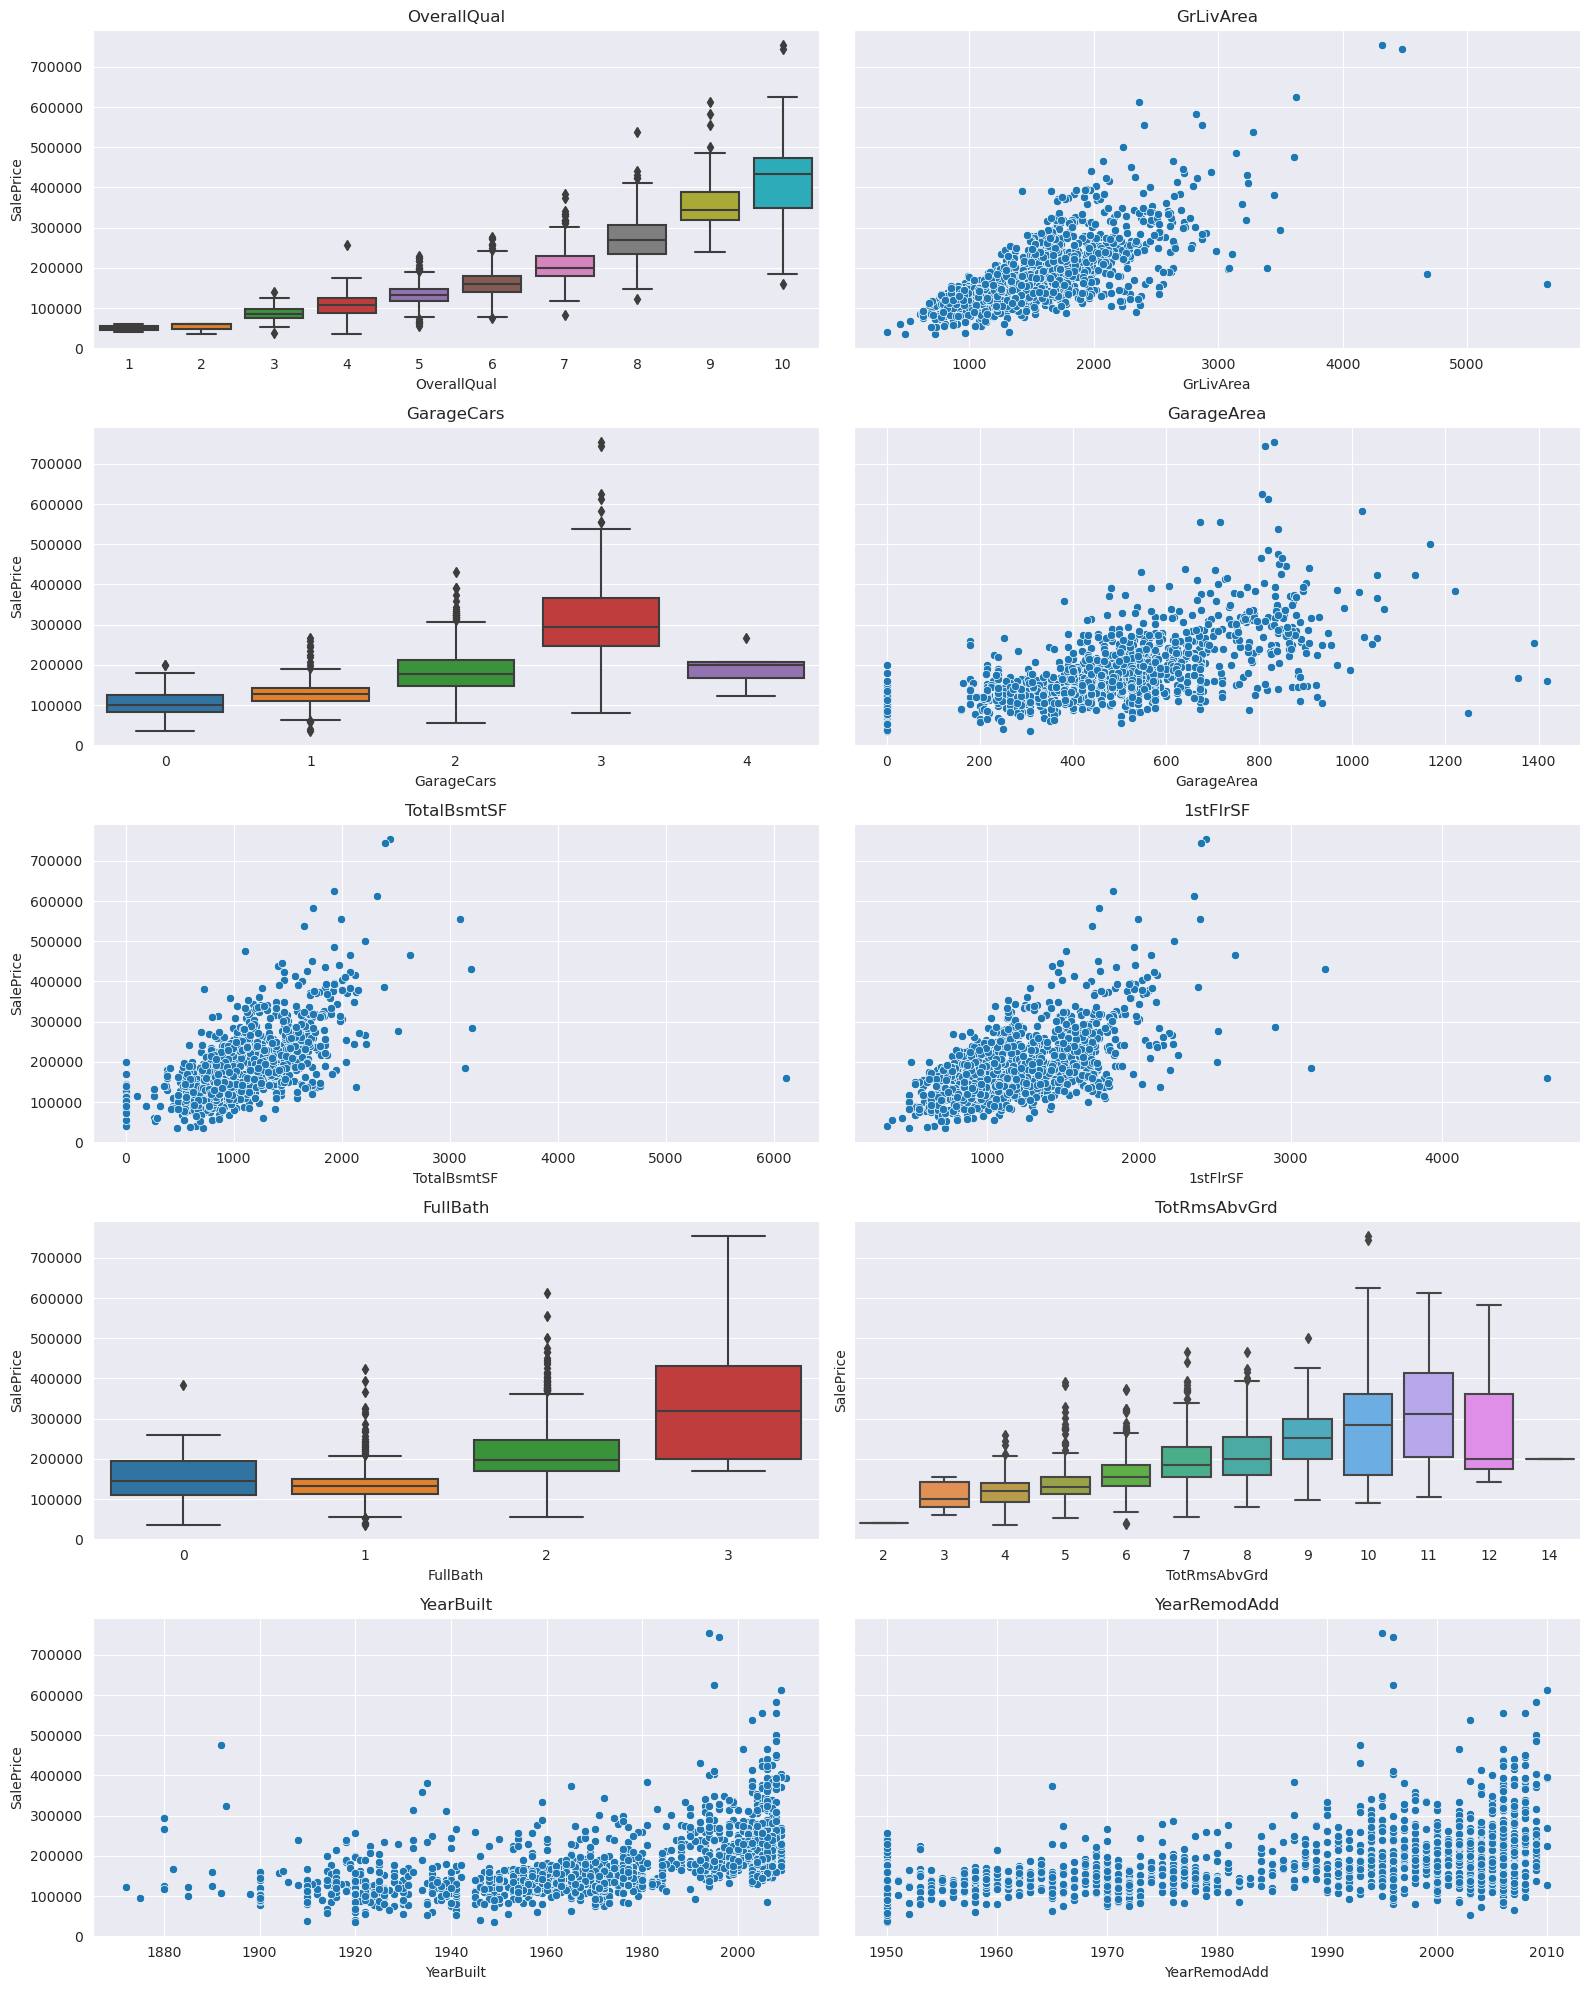

In [14]:
fig, axes = plt.subplots(5, 2, figsize=(16, 20), sharey=True)

for i, col in enumerate(top_10_corrs.index):
    ax = axes[i // 2][i % 2]
    ax.set_title(col)
    
    if df_train[col].nunique() >= 15:
        sns.scatterplot(data=df_train, x=col, y="SalePrice", ax=ax)
    else:
        sns.boxplot(data=df_train, x=col, y="SalePrice", ax=ax)
    
    ax.set_xlabel(col)
    ax.set_ylabel("SalePrice")

fig.tight_layout()
fig.show()

### <span id="3-3"></span>Removing Identified Outliers

In [15]:
outliers = df_train.loc[
    (df_train["TotalBsmtSF"] > 6000) & (df_train["SalePrice"] <= 2e5)
, :]
outliers

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1299,60,RL,313.000,63887,Pave,IR3,Bnk,AllPub,Corner,Gtl,...,0,0,0,480,0,1,2008,New,Partial,160000


In [16]:
df_train.drop(outliers.index, axis=0, inplace=True)

## <span id="4"></span>Data Preprocessing

In [17]:
def create_features(df: pd.DataFrame):
    df["TotalSF"] = df["TotalBsmtSF"] + df["1stFlrSF"] + df["2ndFlrSF"]
    df["TotalBathrooms"] = df["FullBath"] + df["BsmtFullBath"] + \
        0.5 * df["HalfBath"] + 0.5 * df["BsmtHalfBath"]
    df["TotalPorch"] = df["OpenPorchSF"] + df["EnclosedPorch"] + df["3SsnPorch"] + \
        df["ScreenPorch"]
    
    df["HouseAge"] = df["YrSold"] - df["YearBuilt"]
    
    return df

df_train = create_features(df_train)

In [18]:
df_train.drop(["YrSold", "MoSold", "GarageYrBlt", "YearBuilt"], axis=1, inplace=True)

In [19]:
features = df_train.drop("SalePrice", axis=1).columns.values
num_features = [feature for feature in features if is_numeric_dtype(df_train[feature])]
cat_features = list(set(features) - set(num_features))

skewed_feats = []
non_skewed_feats = []

for feature in num_features:
    skewness = df_train[feature].skew()
    
    if np.abs(skewness) <= 1:
        non_skewed_feats.append(feature)
    else:
        skewed_feats.append(feature)

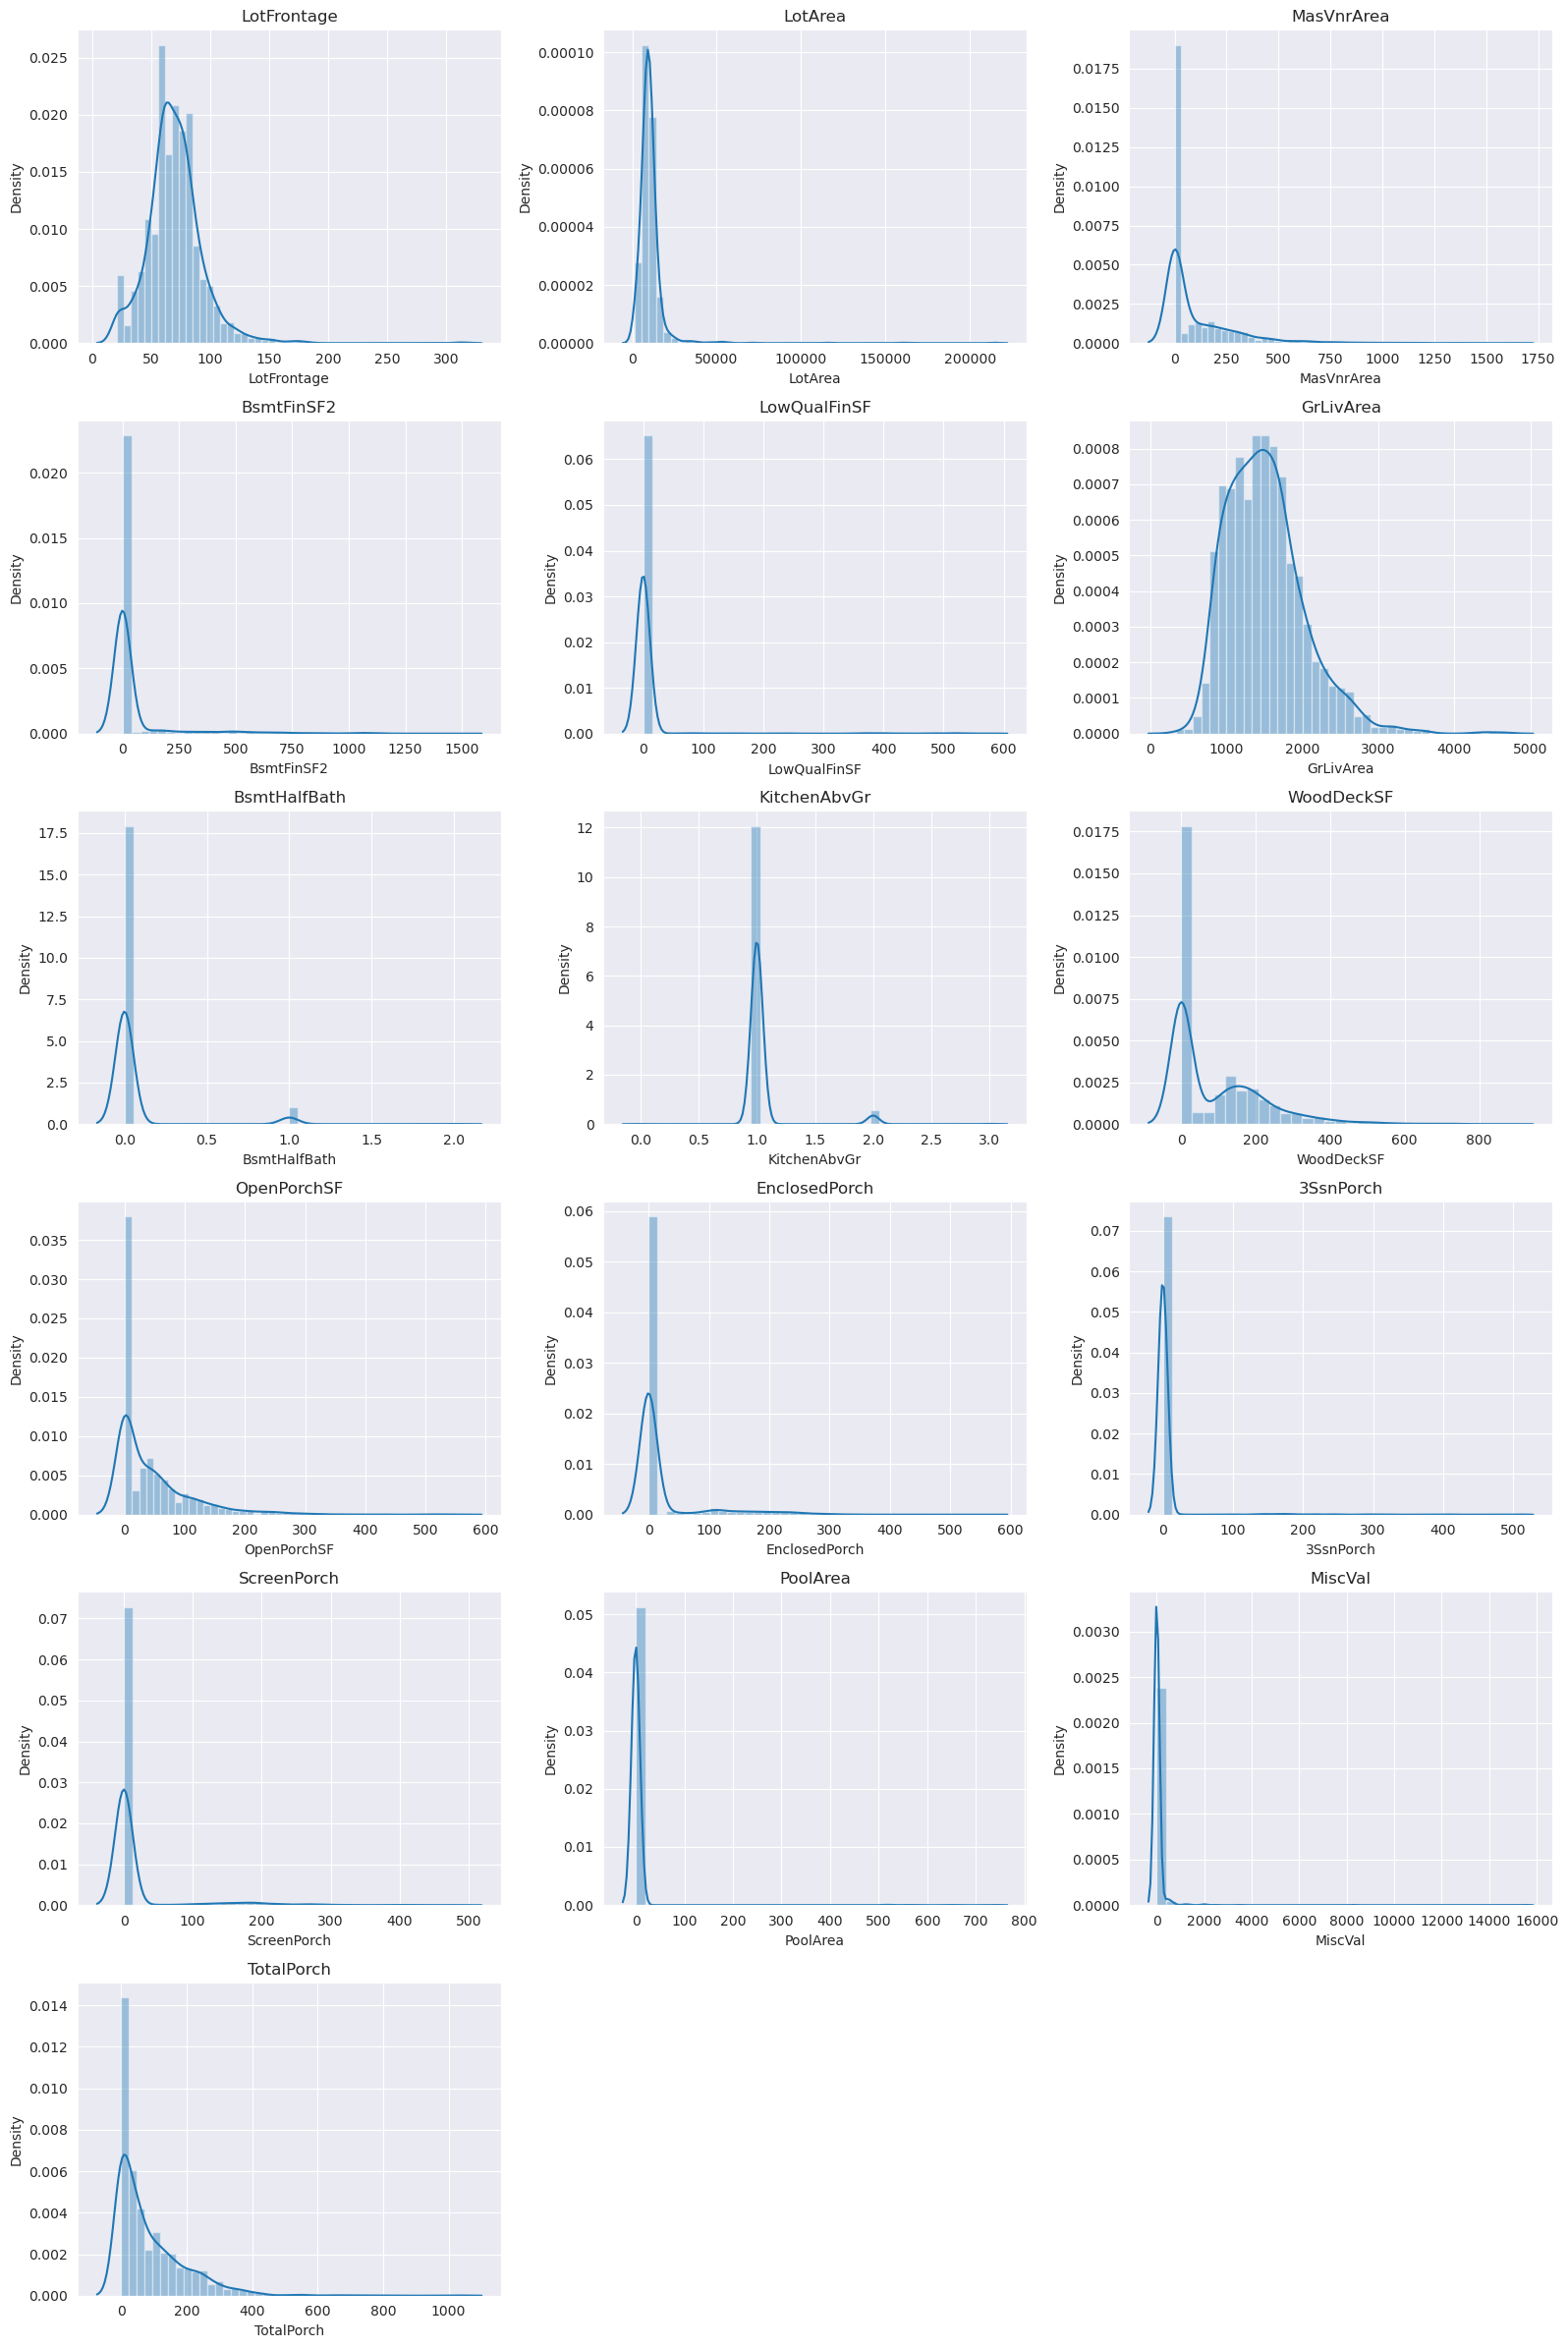

In [20]:
n_cols = 3
n_rows = math.ceil(len(skewed_feats) / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 4))

for i, f in enumerate(skewed_feats):
    ax = axes[i // n_cols][i % n_cols]
    ax.set_title(f)
    sns.distplot(df_train[f], ax=ax)

    
i += 1
while i < (n_rows * n_cols):
    ax = axes[i // n_cols][i % n_cols]
    ax.remove()
    i += 1

fig.tight_layout()
fig.show()

In [21]:
# data imputing, scaling and preprocessing
most_frequent_imputer = SimpleImputer(strategy="most_frequent")
mean_imputer = SimpleImputer(strategy="mean")
median_imputer = SimpleImputer(strategy="median")

# imputer for numeric skewed features: median imputer and log transform
skewed_features_pipe = Pipeline([
    ("skewed_features_imputer", median_imputer),
    ("log_transform", FunctionTransformer(func=np.log1p, inverse_func=np.expm1))
])

preprocessing = ColumnTransformer([
    ("cat_features", most_frequent_imputer, cat_features),
    ("skewed_features", skewed_features_pipe, skewed_feats),
    ("non_skewed_features", mean_imputer, non_skewed_feats)
])

onehot_encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)
ordinal_encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)

standard_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()
robust_scaler = RobustScaler()

In [22]:
X, y = df_train.drop("SalePrice", axis=1), df_train["SalePrice"]
print(X.shape, y.shape)

(1458, 74) (1458,)


## <span id="5"></span>Modeling

In [23]:
# defining model testing and tuning

model_tests = [
    {
        "name": "RandomForest",
        "model": Pipeline([
            ("preprocessing", preprocessing),
            ("encoder", ordinal_encoder),
            ("estimator", RandomForestRegressor(random_state=seed))
        ]),
        "param_grid": {
            "estimator__max_depth": (3, 4, 5, 6),
            "estimator__n_estimators": np.arange(100, 2000, 100)
        }
    },
    {
        "name": "XGBRegressor",
        "model": Pipeline([
            ("preprocessing", preprocessing),
            ("encoder", ordinal_encoder),
            ("estimator", XGBRegressor())
        ]),
        "param_grid": {
            "estimator__eta": np.linspace(0.001, 0.1, 5),
            "estimator__max_depth": (3, 4, 5, 6)
        }
    },
    {
        "name": "SVR",
        "model": Pipeline([
            ("preprocessing", preprocessing),
            ("encoder", onehot_encoder),
            ("scaler", standard_scaler),
            ("estimator", SVR())
        ]),
        "param_grid": {
            "estimator__kernel": ("rbf", "poly", "linear", "sigmoid"),
            "estimator__C": (0.001, 0.01, 0.1, 1, 10, 100, 1000),
            "estimator__gamma": ("scale", "auto")
        }
    }
]

In [24]:
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)

def neg_root_mean_squared_error(estimator, X, y):
    estimator.fit(X, y)
    preds = estimator.predict(X)
    return -1 * np.sqrt(mean_squared_error(y, preds))

models_names = []
best_estimators = []
best_scores = []
for test in model_tests:
    gscv = GridSearchCV(
        test["model"],
        param_grid=test["param_grid"],
        cv=kfold,
        n_jobs=5,
        scoring=neg_root_mean_squared_error
    )
    
    gscv.fit(X, y)
    models_names.append(test["name"])
    best_estimators.append(gscv.best_estimator_)
    best_scores.append(gscv.best_score_)

In [25]:
pd.DataFrame(
    data={
        "Score": np.abs(best_scores)
    },
    index=models_names
)

,Score
RandomForest,14193.043
XGBRegressor,651.302
SVR,0.100


## <span id="6"></span>Competition Submission

In [26]:
df_test = pd.read_csv("../input/house-prices-advanced-regression-techniques/test.csv", index_col=0)
df_test = handle_dtypes(df_test)
df_test = create_features(df_test)
X_test = df_test[features]

In [27]:
model_idx = 1
model = model_tests[model_idx]["model"]

# fit the best model with entire training set
model.fit(X, y)

# generate predictions for the test cases
preds = model.predict(X_test)

In [28]:
subm = pd.DataFrame(data={
    "Id": X_test.index.values,
    "SalePrice": preds
})

subm.head()

,Id,SalePrice
0,1461,100147.938
1,1462,128975.922
2,1463,150411.562
3,1464,179246.156
4,1465,162643.234


In [29]:
subm.to_csv("sample_submission.csv", index=False)